In [1]:
import os

# Go up one level from notebooks/ to project root
os.chdir("..")
print("Current working dir:", os.getcwd())

Current working dir: /zhome/d8/1/207127/HackathonEBM


In [2]:
# Choose your desired accelerator
accelerator = 'cuda'  # 'cpu', 'mps', 'auto'

# VAE, IWAE and HI-VAE, MIWAE
This notebook shows the differences between training a VAE and a IWAE on a simple dataset such as MNIST. IWAE defines a tighter lower bound on the marginal log-likelihood (ELBO). HI-VAE and MIWAE are their corresponding adaptations to operate with partially observed data.

The four models employ amortized variational inference to approximate the log-marginal likelihood via the Evidence Lower Bound (ELBO), by means of a probabilistic encoder and symmetric decoder. 

$$
\mathcal{L}_{\text{VAE}}(\theta, \phi) = \mathbb{E}_{q_\phi(\boldsymbol{z} | \boldsymbol{x})} \left[\log p_\theta(\boldsymbol{x} | \boldsymbol{z}) \right] - KL\left( q_\phi(\boldsymbol{z} | \boldsymbol{x}) \mid\mid p(\boldsymbol{z}) \right)
$$

$$
\mathcal{L}_{\text{IWAE}}(\theta, \phi) = \mathbb{E}_{\boldsymbol{z}_1, ..., \boldsymbol{z}_K \sim q_\phi(\boldsymbol{z} | \boldsymbol{x})} \left[\log \frac{1}{K} \sum_{i=1}^K \frac{ p_\theta(\boldsymbol{x} | \boldsymbol{z}) p(\boldsymbol{z}) }{q_\phi(\boldsymbol{z} | \boldsymbol{x})} \right]
$$

Both HI-VAE and MIWAE assume a factorization per dimension, allowing to separate observed and unobserved parts, i.e. assumming there is conditional independence given the latent variables. This leads to easily marginalizing the unobserved ones, ending in new ELBO on the observed data:
$$
\mathcal{L}_{\text{HI-VAE}}(\theta, \phi) = \mathbb{E}_{q_\phi(\boldsymbol{z} | \boldsymbol{x}^o)} \left[\sum_{d\in \mathcal{O}}^D\log p_\theta(x_d | \boldsymbol{z}) \right] - KL\left( q_\phi(\boldsymbol{z} | \boldsymbol{x}^o) \mid\mid p(\boldsymbol{z}) \right)
$$

$$
\mathcal{L}_{\text{IWAE}}(\theta, \phi) = \mathbb{E}_{\boldsymbol{z}_1, ..., \boldsymbol{z}_K \sim q_\phi(\boldsymbol{z} | \boldsymbol{x}^o)} \left[\log \frac{1}{K} \sum_{i=1}^K \frac{ p_\theta(\boldsymbol{x}^o | \boldsymbol{z}) p(\boldsymbol{z}) }{q_\phi(\boldsymbol{z} | \boldsymbol{x})} \right]
$$


### Implementation
Both VAE/HI-VAE are implemented in the same class `src.models.VAE`. Same happens with IWAE/MIWAE in `src.models.MIWAE`. These classes receive both data batches and mask batches with the observed items. 

Simply by using 'all-ones' masks, one stick to VAE and IWAE. The dataset classes, e.g. `src.data.MyMNIST`, handle this by setting the corresponding hyperparameters.


### Notebook structure

- Part I trains a standard **VAE** on binarized, fully-observed MNIST, using 5 MC samples for the reconstruction term.
- Part II trains an **IWAE** with the same config than Part I, i.e. just changing to the importance-weighted objective.
- Part III trains a **HI-VAE** model on binarized, MNIST data with MCAR missing pattern.
- Part IV trains a **MIWAE** model with the same config than Part III, i.e. just changing to the importance-weighted objective.

## Part I: train VAE on Binary MNIST

### Load config, data, model and trainer

Let's get the config for a VAE trained on binary MNIST:

In [3]:
from hydra import initialize, compose
import os

with initialize(config_path="../configs/"):
    config = compose(config_name="binary_mnist_vae")  

# Specify log and data directories
log_dir = os.environ['LOGDIR'] if 'LOGDIR' in os.environ else './'
config.data.root = os.path.join(log_dir, 'data', config.data.root)
config.train.log_dir = os.path.join(log_dir, 'logs', 'EBM_Hackathon')

# Consider set num_workers to 0 for compatibility with mps
#config.data.dataloader.num_workers = 0
#config.data.dataloader.pin_memory = False


/tmp/ipykernel_2627003/1509355075.py:4: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../configs/"):
/work3/ipeaz/envs/ebm/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'binary_mnist_vae': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


You can explore the config below. For example, let's see which encoder is specified. Feel free to define your own config!

In [4]:
from omegaconf import OmegaConf

print(OmegaConf.to_yaml(config.model.encoder))

_target_: src.layers.ConvEncoder
input_channels: ${data.dim}
input_shape: ${data.shape}
latent_dim: ${model.latent_dim}
hidden_channels:
- 64
- 64
- 128
kernel_sizes:
- 4
- 4
- 4
strides:
- 2
- 2
- 1
paddings:
- 1
- 1
- 0
batch_norm: false



Since we have binarized MNIST, we have to use a Bernoulli likelihood:

In [5]:
config.model.likelihood

{'_target_': 'src.likelihoods.BernoulliLikelihood'}

In [6]:
print('We are using a latent dimension of ' + str(config.model.latent_dim) + '.')

We are using a latent dimension of 32.


Let's get the data loaders:

In [7]:
from src.data.utils import get_data_loaders

loaders = get_data_loaders(config)  #[train_loader, val_loader, ?test_loader]


Let's instantiate our model:

In [8]:
from hydra.utils import instantiate

# Model
vae = instantiate(config.model, cfg=config)


In [9]:
from src.callbacks import get_callbacks

# Callbacks
callbacks = get_callbacks(config, loaders)

The following function will create a proper wandb logger and log folders:

In [10]:
from src.utils import get_wandb_logger

wandb_logger, log_dir = get_wandb_logger(config, "binary_mnist_vae")

Let's create our Trainer:

In [11]:
from pytorch_lightning import Trainer
import torch

# Trainer
trainer = Trainer(
    max_epochs=config.train.epochs,
    logger=wandb_logger,
    default_root_dir=log_dir,
    accelerator=accelerator,
    devices=config.train.devices if torch.cuda.is_available() else 1,
    gradient_clip_val=config.train.gradient_clip_val,
    callbacks=callbacks,
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Now we are ready to fit our VAE:

In [12]:
trainer.fit(vae, *loaders[:2])

You are using a CUDA device ('NVIDIA H100 PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
wandb: Currently logged in as: ipeis to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | encoder    | ConvEncoder         | 329 K  | train
1 | decoder    | ConvDecoder         | 462 K  | train
2 | likelihood | BernoulliLikelihood | 0      | train
-----------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.164     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=400` reached.


In [13]:
import wandb
from src.utils import get_wandb_run_id

# We will save the run ID to retrieve the run later
api = wandb.Api()
id_vae = get_wandb_run_id(log_dir)

wandb.finish()


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇█████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/elbo,▁▁▄▅▅▆▆▆▆▆▇▇▇▇▆▆▇▇▇▆▇▅▇█▇▇▇▇▇▆▇▆▇██▆▇▆▇▇
train/kl,█▆▄▅▇█▄▆▅▅▅▆▆▅▆▄▅▅▅▃▅▄▄▇▄▄▅▂▁▅▁▄▃▄▃▃▂▄▃▅
train/log_px,▁▄▅▅▅▄▆▅▆▇▇▆▆▆█▄▆▆▆▆▆▆▇▅▆▆▆▇▇▇▆▇▇▆▅▇█▇▆▇
train/loss,█▅▃▃▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▂▂▂▂▁▁▁▁▂▂▁▂
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▇▇▇▇████
val/elbo,▁▂▂▃▂▃▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇█▇████████████
val/kl,▄▆▅█▇▇▆▃▅▄▃▄▅▄▄▄▂▂▃▃▃▂▃▃▄▂▂▃▂▂▃▃▂▂▄▁▂▃▁▂
val/log_px,▁▁▄▆▄▆▅▆▆▆▆▆▅▆▆▅▅▇▇▇▅▆▇█▇█▇▇▇▇▇█▆▇▇▇▇▇██
+2,...


# Part II: Train IWAE on Binary MNIST

We'll just add a minimal modification to train a MIWAE. The architecture and latent size will be identical.

In [14]:
with initialize(config_path="../configs/"):
    config = compose(config_name="binary_mnist_iwae")  

# Specify log and data directories
log_dir = os.environ['LOGDIR'] if 'LOGDIR' in os.environ else './'
config.data.root = os.path.join(log_dir, 'data', config.data.root)
config.train.log_dir = os.path.join(log_dir, 'logs', 'EBM_Hackathon')

# Consider set num_workers to 0 for compatibility with mps
#config.data.dataloader.num_workers = 0
#config.data.dataloader.pin_memory = False


/tmp/ipykernel_2627003/2730586041.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../configs/"):
/work3/ipeaz/envs/ebm/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'binary_mnist_iwae': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


The only changed introduced in this config is the `model._base_target_`, pointing to the `MIWAE` class.

In [15]:
print(OmegaConf.to_yaml(config.model))

_target_: src.models.MIWAE
_recursive_: false
K: 5
latent_dim: 32
likelihood:
  _target_: src.likelihoods.BernoulliLikelihood
encoder:
  _target_: src.layers.ConvEncoder
  input_channels: ${data.dim}
  input_shape: ${data.shape}
  latent_dim: ${model.latent_dim}
  hidden_channels:
  - 64
  - 64
  - 128
  kernel_sizes:
  - 4
  - 4
  - 4
  strides:
  - 2
  - 2
  - 1
  paddings:
  - 1
  - 1
  - 0
  batch_norm: false
decoder:
  _target_: src.layers.ConvDecoder
  latent_dim: ${model.latent_dim}
  output_channels: ${data.dim}
  output_shape: ${data.shape}
  hidden_channels: ${reverse:${model.encoder.hidden_channels}}
  kernel_sizes: ${reverse:${model.encoder.kernel_sizes}}
  strides: ${reverse:${model.encoder.strides}}
  paddings: ${reverse:${model.encoder.paddings}}
  batch_norm: false



In [16]:
# Logger
wandb_logger, log_dir = get_wandb_logger(config, "binary_mnist_iwae")

# Model
iwae = instantiate(config.model, cfg=config)

# Trainer
trainer = Trainer(
    max_epochs=config.train.epochs,
    logger=wandb_logger,
    default_root_dir=log_dir,
    accelerator=accelerator,
    devices=config.train.devices if torch.cuda.is_available() else 1,
    gradient_clip_val=config.train.gradient_clip_val,
    callbacks=callbacks,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Now we are ready to fit our IWAE:

In [17]:
trainer.fit(iwae, *loaders[:2])

/work3/ipeaz/envs/ebm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /dtu/p1/ipeaz/logs/EBM_Hackathon/binary_mnist_vae-2025-10-28T17-08-19/EBM_Hackathon/ag6gc1w4/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | encoder    | ConvEncoder         | 329 K  | train
1 | decoder    | ConvDecoder         | 462 K  | train
2 | likelihood | BernoulliLikelihood | 0      | train
-----------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.164     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=400` reached.


In [18]:
import matplotlib.pyplot as plt

api = wandb.Api()
id_iwae = get_wandb_run_id(log_dir)

wandb.finish()

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇█████
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/elbo,▁▃▁▂▂▃▃▄▅▄▄▃▇▃▄▅▂▄▂▄▄▄▄▂▅▇▃▆█▃▅█▇▅▅▆▆▅▆▇
train/loss,█▆▃▃▃▃▃▃▄▃▃▃▄▃▃▂▂▂▃▂▂▂▃▂▃▃▃▁▂▃▂▂▂▁▃▂▃▃▂▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
val/elbo,▁▄▅▅▆▆▇▇▇▇▇▇▇▇▇█████████████████████████
val/loss,█▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,399
lr-Adam,0.0001
train/elbo,-81.33011


In [19]:
# Give it 10 seconds to sync
import time
time.sleep(10)

elbo = {}
steps = {}
for run_id, name in zip([id_vae, id_iwae], ['vae', 'iwae']):
    run = api.run(f"ipeis/EBM_Hackathon/runs/{run_id}")  # replace with your project/run ID
    history = run.history()
    history = history[history['val/elbo'].notna()]

    elbo[name] = history['val/elbo'].tolist()
    steps[name] = history['_step'].tolist()

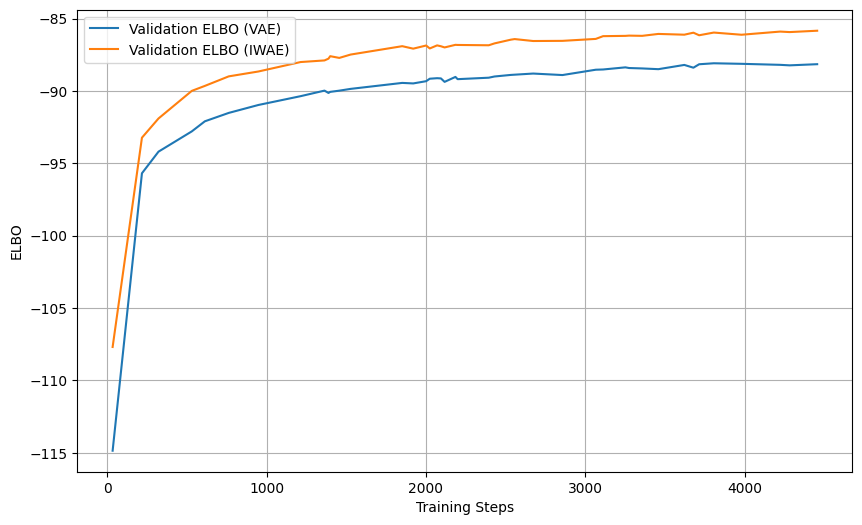

In [20]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(10,6))
plt.plot(steps['vae'], elbo['vae'], label='Validation ELBO (VAE)', color='tab:blue')
plt.plot(steps['iwae'], elbo['iwae'], label='Validation ELBO (IWAE)', color='tab:orange')

plt.grid()
plt.xlabel('Training Steps')
plt.ylabel('ELBO')
plt.legend()

Let's have a look at samples from both models:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


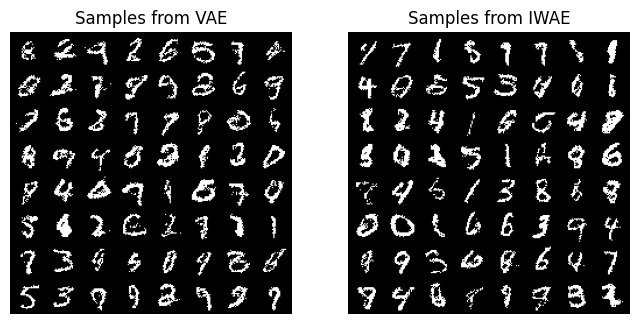

In [21]:
from torchvision.utils import make_grid

num_samples = 64

samples_vae = vae.sample(num_samples=num_samples)
samples_vae = make_grid(samples_vae, nrow=8)

samples_iwae = iwae.sample(num_samples=num_samples)
samples_iwae = make_grid(samples_iwae, nrow=8)

# Plot samples side by side
fig, axes = plt.subplots(1,2, figsize=(8, 4))
axes[0].imshow(samples_vae.permute(1, 2, 0).cpu().numpy(), cmap='gray')
axes[0].set_title('Samples from VAE')
axes[0].axis('off')
axes[1].imshow(samples_iwae.permute(1, 2, 0).cpu().numpy(), cmap='gray')
axes[1].set_title('Samples from IWAE')
axes[1].axis('off')
plt.show()




Let's have a look now at their reconstructions:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


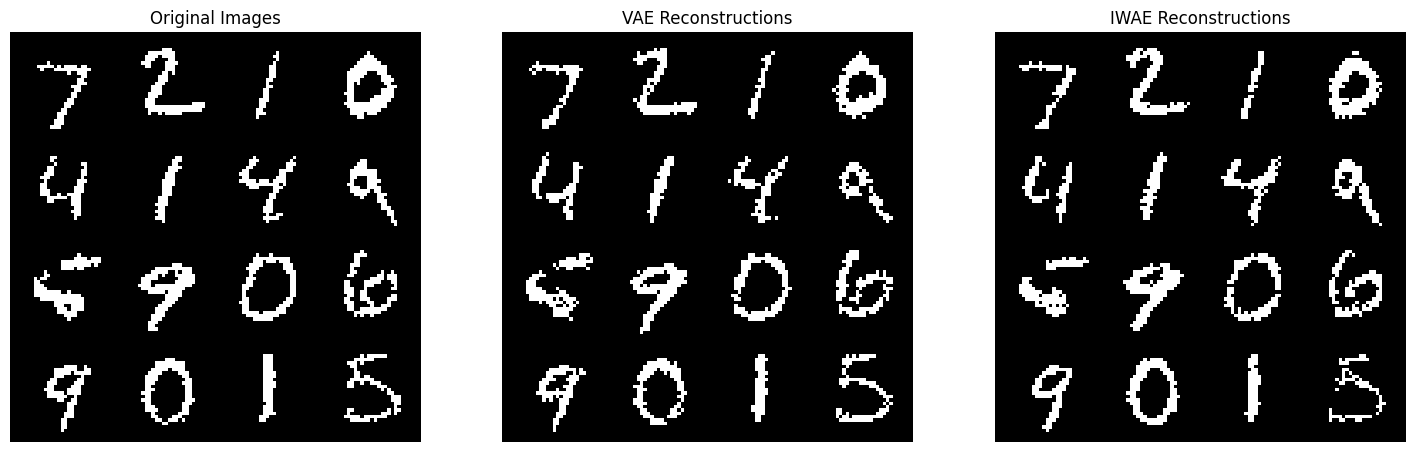

In [22]:
import torch
import numpy as np

num_recs = 16
val_batch = next(iter(loaders[1]))
val_batch = val_batch[0][:num_recs].to(vae.device)  # Get first 16 images

recon_vae = vae.reconstruct(val_batch)
recon_vae = make_grid(recon_vae, nrow=int(np.sqrt(num_recs)))
recon_iwae = iwae.reconstruct(val_batch, torch.ones_like(val_batch))  # Full mask
recon_iwae = make_grid(recon_iwae, nrow=int(np.sqrt(num_recs)))

# Plot reconstructions side by side
fig, axes = plt.subplots(1,3, figsize=(18, 6))

# Original images
axes[0].imshow(make_grid(val_batch, nrow=int(np.sqrt(num_recs))).permute(1, 2, 0).cpu().numpy(), cmap='gray')
axes[0].set_title('Original Images')
axes[0].axis('off')
# VAE Reconstructions
axes[1].imshow(recon_vae.permute(1, 2, 0).cpu().numpy(), cmap='gray')
axes[1].set_title('VAE Reconstructions')
axes[1].axis('off')
# IWAE Reconstructions
axes[2].imshow(recon_iwae.permute(1, 2, 0).cpu().numpy(), cmap='gray')
axes[2].set_title('IWAE Reconstructions')
axes[2].axis('off')
plt.show()  

# Part III: Train HI-VAE on partially observed (MCAR) Binary MNIST


The only difference wrt to the VAE config will be the way we instantiate the `MyMNIST` class. Let's load the config:

In [23]:
with initialize(config_path="../configs/"):
    config = compose(config_name="mcar_binary_mnist_hivae")  

# Specify log and data directories
log_dir = os.environ['LOGDIR'] if 'LOGDIR' in os.environ else './'
config.data.root = os.path.join(log_dir, 'data', config.data.root)
config.train.log_dir = os.path.join(log_dir, 'logs', 'EBM_Hackathon')

# Consider set num_workers to 0 for compatibility with mps
#config.data.dataloader.num_workers = 0
#config.data.dataloader.pin_memory = False


/tmp/ipykernel_2627003/2441414894.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../configs/"):
/work3/ipeaz/envs/ebm/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'mcar_binary_mnist_hivae': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [24]:
print(OmegaConf.to_yaml(config.data.dataset))

_target_: src.data.MyMNIST
root: ${data.root}
download: true
transform:
  _target_: torchvision.transforms.Compose
  transforms:
  - _target_: torchvision.transforms.ToTensor
  - _target_: src.data.Binarize
missing_rate: 0.5
threshold: 0



As you can see, there is a `missing_rate` parameter that will generate MCAR missing masks with an average pixel missing probability of 0.5. The `VAE` class will process these masks accordingly.

In [25]:
# Logger
wandb_logger, log_dir = get_wandb_logger(config, 'mcar_binary_mnist_hivae')

# Data loaders
loaders = get_data_loaders(config)  #[train_loader, val_loader, ?test_loader]

# Model
hivae = instantiate(config.model, cfg=config)

# Trainer
trainer = Trainer(
    max_epochs=config.train.epochs,
    logger=wandb_logger,
    default_root_dir=log_dir,
    accelerator=accelerator,
    devices=config.train.devices if torch.cuda.is_available() else 1,
    gradient_clip_val=config.train.gradient_clip_val,
    callbacks=callbacks,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Now we are ready to fit our HIVAE:

In [26]:
trainer.fit(hivae, *loaders[:2])

/work3/ipeaz/envs/ebm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /dtu/p1/ipeaz/logs/EBM_Hackathon/binary_mnist_vae-2025-10-28T17-08-19/EBM_Hackathon/ag6gc1w4/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | encoder    | ConvEncoder         | 329 K  | train
1 | decoder    | ConvDecoder         | 462 K  | train
2 | likelihood | BernoulliLikelihood | 0      | train
-----------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.164     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=400` reached.


In [27]:
# We will save the run ID to retrieve the run later
api = wandb.Api()
id_hivae = get_wandb_run_id(log_dir)

wandb.finish()

epoch,▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
lr-Adam,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/elbo,▁▂▃▃▃▃█▂▅▅▇▄▁▅▅▅▂▄▅▇▃▃▆▃▃▆▂▅▇▆▆▇▅▇▃▇▇▄█▇
train/kl,▂▂▁▇█▅▅▆▁▆▅▅▅▅▄█▃▃▂▇▆▄▇▆▅▆▂▂▅▅▂▅▅▃▅▃▁▃▂▄
train/log_px,▁▆▇▇▇▇▇▇▇▇▇█▇███▇██▇▇▇▇██████▇██▇▇██████
train/loss,█▇▆▄▃▃▃▃▃▄▃▃▃▂▄▁▂▃▃▃▃▂▂▃▃▃▃▁▂▄▃▁▃▃▃▃▂▂▂▂
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██
val/elbo,▁▂▃▄▆▆▆▇▇▇▇▇▇▇▇██▇██████████████████████
val/kl,▂█▇▇█▃▃▆▂▃▅▃▄▂▅▁▅▃▂▂▂▅▂▂▂▄▁▂▃▂▃▂▁▂▁▁▃▃▂▃
val/log_px,▁▅▅▅▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████▇▇▇██▇█████
+2,...


# Part IV: Train MIWAE on MCAR Binary MNIST

We'll just add a minimal modification to train a MIWAE. 

In [28]:
with initialize(config_path="../configs/"):
    config = compose(config_name="mcar_binary_mnist_miwae")  

# Specify log and data directories
log_dir = os.environ['LOGDIR'] if 'LOGDIR' in os.environ else './'
config.data.root = os.path.join(log_dir, 'data', config.data.root)
config.train.log_dir = os.path.join(log_dir, 'logs', 'EBM_Hackathon')

# Consider set num_workers to 0 for compatibility with mps
#config.data.dataloader.num_workers = 0
#config.data.dataloader.pin_memory = False


/tmp/ipykernel_2627003/2326371351.py:1: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="../configs/"):
/work3/ipeaz/envs/ebm/lib/python3.10/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'mcar_binary_mnist_miwae': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [29]:
# Logger
wandb_logger, log_dir= get_wandb_logger(config, 'mcar_binary_mnist_miwae')

# Data loaders
loaders = get_data_loaders(config)  #[train_loader, val_loader, ?test_loader]

# Model
miwae = instantiate(config.model, cfg=config)

# Trainer
trainer = Trainer(
    max_epochs=config.train.epochs,
    logger=wandb_logger,
    default_root_dir=log_dir,
    accelerator=accelerator,
    devices=config.train.devices if torch.cuda.is_available() else 1,
    gradient_clip_val=config.train.gradient_clip_val,
    callbacks=callbacks,
)

Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Now we are ready to fit our MIWAE:

In [30]:
trainer.fit(miwae, *loaders[:2])

/work3/ipeaz/envs/ebm/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:751: Checkpoint directory /dtu/p1/ipeaz/logs/EBM_Hackathon/binary_mnist_vae-2025-10-28T17-08-19/EBM_Hackathon/ag6gc1w4/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name       | Type                | Params | Mode 
-----------------------------------------------------------
0 | encoder    | ConvEncoder         | 329 K  | train
1 | decoder    | ConvDecoder         | 462 K  | train
2 | likelihood | BernoulliLikelihood | 0      | train
-----------------------------------------------------------
791 K     Trainable params
0         Non-trainable params
791 K     Total params
3.164     Total estimated model params size (MB)
20        Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=400` reached.


In [31]:
import matplotlib.pyplot as plt

api = wandb.Api()
id_miwae = get_wandb_run_id(log_dir)

In [32]:
# Give it 10 seconds to sync
import time
time.sleep(10)

elbo = {}
steps = {}
for run_id, name in zip([id_hivae, id_miwae], ['hivae', 'miwae']):
    run = api.run(f"ipeis/EBM_Hackathon/runs/{run_id}")  # replace with your project/run ID
    history = run.history()
    history = history[history['val/elbo'].notna()]

    elbo[name] = history['val/elbo'].tolist()
    steps[name] = history['_step'].tolist()

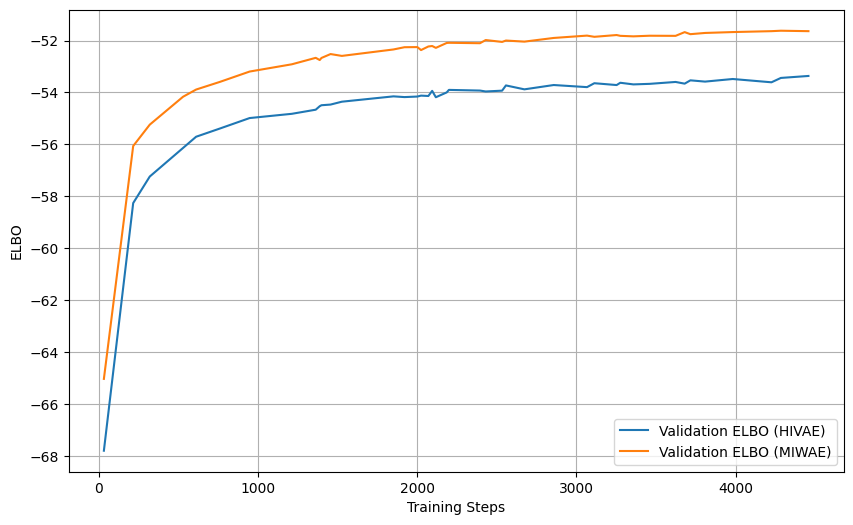

In [33]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(10,6))
plt.plot(steps['hivae'], elbo['hivae'], label='Validation ELBO (HIVAE)', color='tab:blue')
plt.plot(steps['miwae'], elbo['miwae'], label='Validation ELBO (MIWAE)', color='tab:orange')

plt.grid()
plt.xlabel('Training Steps')
plt.ylabel('ELBO')
plt.legend()

Let's have a look at samples from both models:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


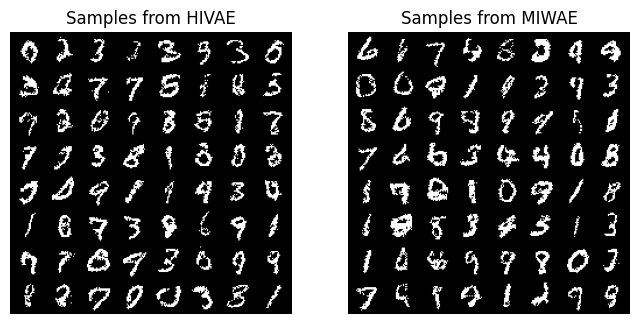

In [34]:
from torchvision.utils import make_grid

num_samples = 64

samples_hivae = vae.sample(num_samples=num_samples)
samples_hivae = make_grid(samples_hivae, nrow=8)

samples_miwae = iwae.sample(num_samples=num_samples)
samples_miwae = make_grid(samples_miwae, nrow=8)

# Plot samples side by side
fig, axes = plt.subplots(1,2, figsize=(8, 4))
axes[0].imshow(samples_hivae.permute(1, 2, 0).cpu().numpy(), cmap='gray')
axes[0].set_title('Samples from HIVAE')
axes[0].axis('off')
axes[1].imshow(samples_miwae.permute(1, 2, 0).cpu().numpy(), cmap='gray')
axes[1].set_title('Samples from MIWAE')
axes[1].axis('off')
plt.show()

Let's have a look now at their reconstructions:


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


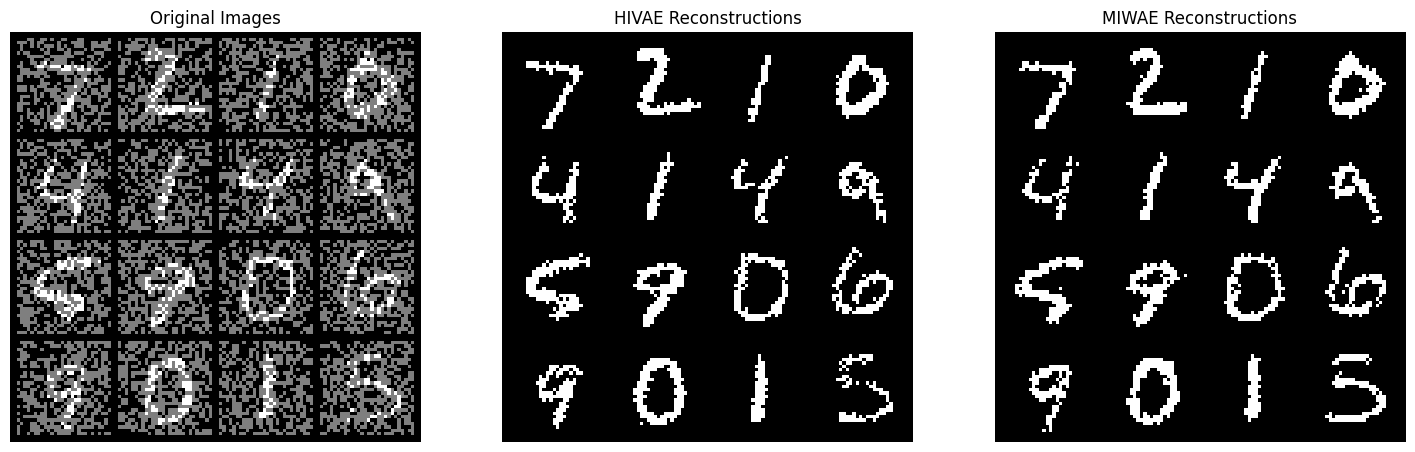

In [35]:
import numpy as np

val_batch = next(iter(loaders[1]))

images, masks = val_batch
images = images[:num_recs].to(vae.device)  # Get first 16 images
masks = masks[:num_recs].to(vae.device)  # Get first 16 masks

recon_hivae = hivae.reconstruct(images*masks, masks)
recon_hivae = make_grid(recon_hivae, nrow=int(np.sqrt(num_recs)))
recon_miwae = miwae.reconstruct(images*masks, masks)
recon_miwae = make_grid(recon_miwae, nrow=int(np.sqrt(num_recs)))

# Plot reconstructions side by side
fig, axes = plt.subplots(1,3, figsize=(18, 6))

# Original images
images = images * masks
# Move to [0,1]
images = images * 0.5 + 0.5
images = make_grid(images, nrow=int(np.sqrt(num_recs)))
axes[0].imshow(images.permute(1, 2, 0).cpu().numpy(), cmap='gray')
axes[0].set_title('Original Images')
axes[0].axis('off')
# HIVAE Reconstructions
axes[1].imshow(recon_hivae.permute(1, 2, 0).cpu().numpy(), cmap='gray')
axes[1].set_title('HIVAE Reconstructions')
axes[1].axis('off')
# MIWAE Reconstructions
axes[2].imshow(recon_miwae.permute(1, 2, 0).cpu().numpy(), cmap='gray')
axes[2].set_title('MIWAE Reconstructions')
axes[2].axis('off')
plt.show()  

Let's now compare their reconstruction of partially observed data agains VAE and IWAE:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


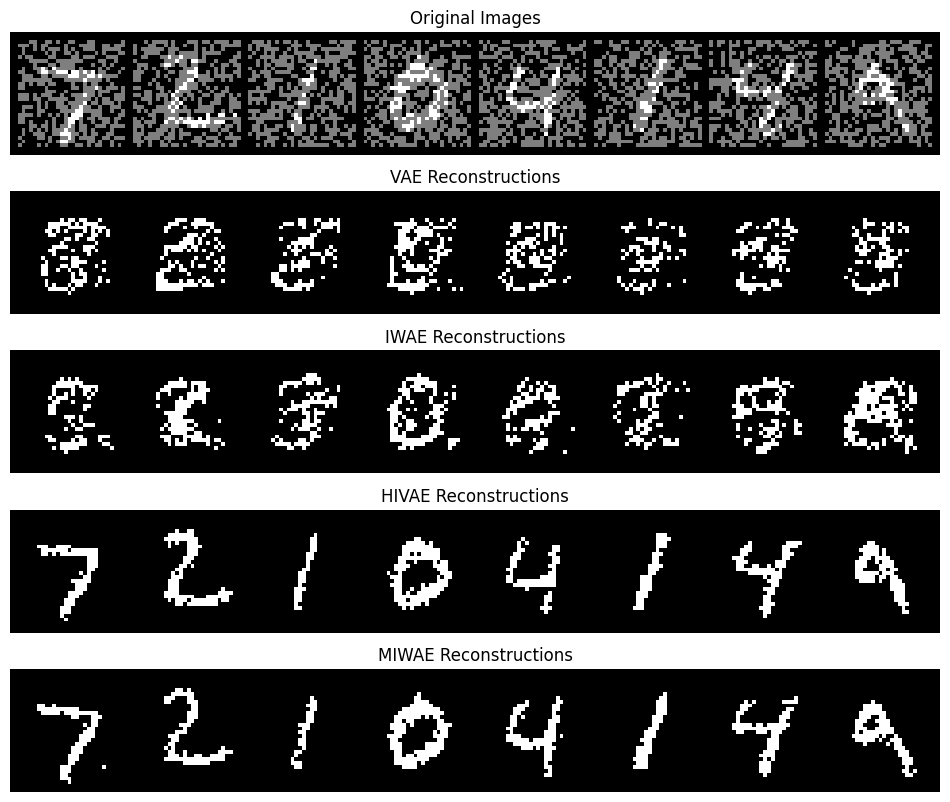

In [36]:
import numpy as np

val_batch = next(iter(loaders[1]))

num_recs = 8
images, masks = val_batch
images = images[:num_recs].to(vae.device)  # Get first 8 images
masks = masks[:num_recs].to(vae.device)  # Get first 8 masks

recon_vae = vae.reconstruct(images*masks)
recon_iwae = iwae.reconstruct(images*masks) 
recon_hivae = hivae.reconstruct(images*masks, masks)
recon_miwae = miwae.reconstruct(images*masks, masks)

# Plot reconstructions side by side
fig, axes = plt.subplots(5, 1, figsize=(12, 10))

# Original images
images = images * masks
# Move to [0,1]
images = images * 0.5 + 0.5
images = make_grid(images, nrow=num_recs)
axes[0].imshow(images.permute(1, 2, 0).cpu().numpy(), cmap='gray')
axes[0].set_title('Original Images')
axes[0].axis('off')
# VAE Reconstructions
recon_vae = make_grid(recon_vae, nrow=num_recs)
axes[1].imshow(recon_vae.permute(1, 2, 0).cpu().numpy(), cmap='gray')
axes[1].set_title('VAE Reconstructions')
axes[1].axis('off')
# IWAE Reconstructions
recon_iwae = make_grid(recon_iwae, nrow=num_recs)
axes[2].imshow(recon_iwae.permute(1, 2, 0).cpu().numpy(), cmap='gray')
axes[2].set_title('IWAE Reconstructions')
axes[2].axis('off') 
# HIVAE Reconstructions
recon_hivae = make_grid(recon_hivae, nrow=num_recs)
axes[3].imshow(recon_hivae.permute(1, 2, 0).cpu().numpy(), cmap='gray')
axes[3].set_title('HIVAE Reconstructions')
axes[3].axis('off')
# MIWAE Reconstructions
recon_miwae = make_grid(recon_miwae, nrow=num_recs)
axes[4].imshow(recon_miwae.permute(1, 2, 0).cpu().numpy(), cmap='gray')
axes[4].set_title('MIWAE Reconstructions')
axes[4].axis('off')
plt.show()